<a href="https://colab.research.google.com/github/antounes/practical-ml-for-computer-vision/blob/main/02b_neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Flowers Image Classification Using a Neural Network

## Enable GPU and set up helper functions 

In [1]:
import tensorflow as tf
print(tf.version.VERSION)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found - On for CPU time!')
else:
  print('Found GPU at: {}'.format(device_name))

2.7.0
Found GPU at: /device:GPU:0


In [2]:
# Helper functions

def training_plot(metrics, history):
  f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
  for idx, metric in enumerate(metrics):
    ax[idx].plot(history.history[metric], ls='dashed')
    ax[idx].set_xlabel('Epochs')
    ax[idx].set_ylabel(metric)
    ax[idx].plot(history.history['val_'+metric]);
    ax[idx].legend(['train_'+metric, 'val_'+metric])

# Call model.predict() on a few images in the evaluation dataset

def plot_predicitons(filename):
  f, ax = plt.subplots(3, 5, figsize=(25, 15))
  dataset = tf.data.TextLineDataset(filename).map(decode_csv)
  for idx, (img, label) in enumerate(dataset.take(15)):
    ax[idx//5, idx%5].imshow(img.numpy());
    batch_image = tf.reshape(img, [1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
    batch_pred = model.predict(batch_image)
    pred = batch_pred[0]
    label = CLASS_NAMES(label.numpy())
    pred_label_index = tf.math.argmax(pred).numpy()
    pred_label = CLASS_NAMES[pred_label_index]
    prob = pred[pred_label_index]
    ax[idx//5, idx%5].set_title('{}: {} ({:.4f})'.format(label, pred_label, prob))

def show_trained_weights(model):
  # CLASS_NAMES is ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
  LAYER = 1 # Layer 0 flattens the image, layer=1 is the first dense layer
  WEIGHT_TYPE = 0 # 0 for weight, 1 for bias

  f, ax = plt.subplots(1, 5, figsize=(15, 15))
  for flower in range(len(CLASS_NAMES)):
    weights = model.layers[LAYER].get_weights()[WEIGHT_TYPE][:, flower]
    min_wt = tf.math.reduce_min(weights).numpy()
    max_wt = tf.math.reduce_max(weights).numpy()
    flower_name = CLASS_NAMES[flower]
    print('Scaling weights for {} in {} to {}'.format(flower_name, min_wt, max_wt))
    weights = (weights - min_wt) / (max_wt - min_wt)
    ax[flower].ishow(weights.reshape(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS));
    ax[flower].set_title(flower_name);

In [3]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3

def read_and_decode(filename, reshape_dims):
  # Read the file
  img = tf.io.read_file(filename)
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
  # Use `convert_image_dtype` to convert to floats in the [0, 1] range
  img = tf.image.convert_image_dtype(img, tf.float32)
  # Resize the image to the desired size
  return tf.image.resize(img, reshape_dims)

CLASS_NAMES = [item.numpy().decode('utf8') 
for item in tf.strings.regex_replace(tf.io.gfile.glob('gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/*'), 
                                     'gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/', '')
]
CLASS_NAMES = [item for item in CLASS_NAMES if item.find('.')==-1]
print('These are the available classes:', CLASS_NAMES)

# The label is the index into CLASS_NAMES array
def decode_csv(csv_row):
  record_defaults = ['path', 'flower']
  filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  label = tf.argmax(tf.math.equal(CLASS_NAMES, label_string))
  return img, label

These are the available classes: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## A Neural Network Model

### Training the neural network

In [4]:
# Adding one non-linear layer in the middle

BATCH_SIZE = 32

train_dataset = tf.data.TextLineDataset(
    'gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv'
).map(decode_csv).batch(BATCH_SIZE)

eval_dataset = tf.data.TextLineDataset(
    'gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/eval_set.csv'
).map(decode_csv).batch(BATCH_SIZE)

# Neural network with one hidden layer
model = tf.keras.Sequential([
          tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
          tf.keras.layers.Dense(units=128, activation='relu'),
          tf.keras.layers.Dense(units=len(CLASS_NAMES), activation='softmax')
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
history = model.fit(train_dataset, validation_data=eval_dataset, epochs=10)

Epoch 1/10
104/104 [==============================] - 146s 1s/step - loss: 14.6977 - accuracy: 0.3270 - val_loss: 4.4084 - val_accuracy: 0.3378
Epoch 2/10
104/104 [==============================] - 116s 1s/step - loss: 5.5682 - accuracy: 0.3776 - val_loss: 6.3705 - val_accuracy: 0.3378
Epoch 3/10
104/104 [==============================] - 104s 999ms/step - loss: 4.1505 - accuracy: 0.3742 - val_loss: 2.2856 - val_accuracy: 0.3784
Epoch 4/10
104/104 [==============================] - 100s 960ms/step - loss: 1.6268 - accuracy: 0.3291 - val_loss: 1.5633 - val_accuracy: 0.2865
Epoch 5/10
104/104 [==============================] - 98s 944ms/step - loss: 1.4490 - accuracy: 0.3930 - val_loss: 1.5517 - val_accuracy: 0.3622
Epoch 6/10
104/104 [==============================] - 98s 942ms/step - loss: 1.3850 - accuracy: 0.4124 - val_loss: 1.9724 - val_accuracy: 0.3865
Epoch 7/10
104/104 [==============================] - 97s 933ms/step - loss: 1.3954 - accuracy: 0.4142 - val_loss: 1.6903 - val_acc

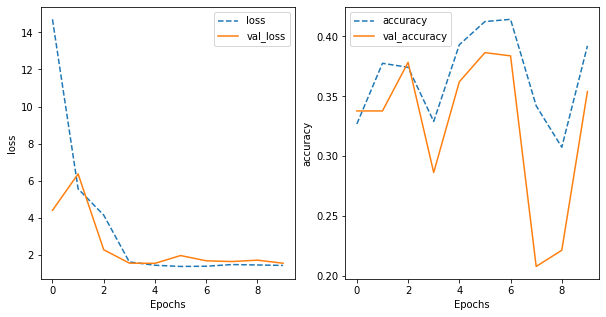

In [5]:
training_plot(['loss', 'accuracy'], history)

### Learning rate

In [6]:
# parametrise to the values in the previous cell

def train_and_evaluate(batch_size=32,
                       lrate=0.001, # default learning rate in Adam constructor
                       l1=0,
                       l2=0,
                       num_hidden=128):
  regularizer = tf.keras.regularizers.l1_l2(l1, l2)

  train_dataset = tf.data.TextLineDataset(
      'gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv'
  ).map(decode_csv).batch(batch_size)

  eval_dataset = tf.data.TextLineDataset(
      'gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/eval_set.csv'
  ).map(decode_csv).batch(batch_size)

  # Neural network with one hidden layer
  model = tf.keras.Sequential([
            tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
            tf.keras.layers.Dense(units=num_hidden, kernel_regularizer=regularizer, activation='relu'),
            tf.keras.layers.Dense(units=len(CLASS_NAMES),
                                  kernel_regularizer=regularizer,
                                  activation='softmax')
  ])
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])
  
  history = model.fit(train_dataset, validation_data=eval_dataset, epochs=10)
  training_plot(['loss', 'accuracy'], history)
  
  return model

Epoch 1/10
104/104 [==============================] - 99s 948ms/step - loss: 2.1626 - accuracy: 0.3130 - val_loss: 1.5075 - val_accuracy: 0.3946
Epoch 2/10
104/104 [==============================] - 98s 943ms/step - loss: 1.4461 - accuracy: 0.4167 - val_loss: 1.5101 - val_accuracy: 0.4216
Epoch 3/10
104/104 [==============================] - 100s 960ms/step - loss: 1.3576 - accuracy: 0.4570 - val_loss: 1.4457 - val_accuracy: 0.3676
Epoch 4/10
104/104 [==============================] - 103s 987ms/step - loss: 1.3048 - accuracy: 0.4836 - val_loss: 1.3525 - val_accuracy: 0.4541
Epoch 5/10
104/104 [==============================] - 101s 970ms/step - loss: 1.2386 - accuracy: 0.5109 - val_loss: 1.3255 - val_accuracy: 0.4486
Epoch 6/10
104/104 [==============================] - 100s 958ms/step - loss: 1.2054 - accuracy: 0.5294 - val_loss: 1.3079 - val_accuracy: 0.4541
Epoch 7/10
104/104 [==============================] - 97s 933ms/step - loss: 1.1711 - accuracy: 0.5367 - val_loss: 1.2887 - va

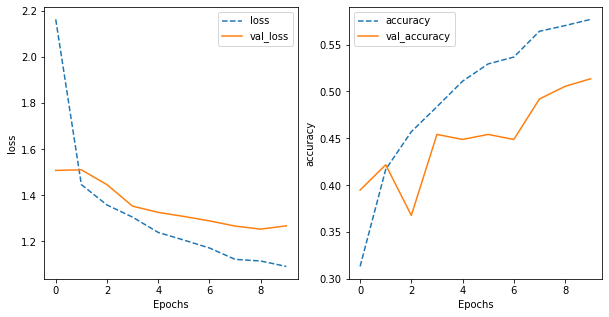

In [7]:
model = train_and_evaluate(batch_size=32, lrate=0.0001, l1=0, l2=0, num_hidden=128)

Epoch 1/10
104/104 [==============================] - 99s 952ms/step - loss: 2.7536 - accuracy: 0.3506 - val_loss: 2.4878 - val_accuracy: 0.3243
Epoch 2/10
104/104 [==============================] - 102s 979ms/step - loss: 1.6614 - accuracy: 0.4312 - val_loss: 1.9804 - val_accuracy: 0.3757
Epoch 3/10
104/104 [==============================] - 96s 922ms/step - loss: 1.4286 - accuracy: 0.4745 - val_loss: 1.9054 - val_accuracy: 0.3568
Epoch 4/10
104/104 [==============================] - 98s 941ms/step - loss: 1.6074 - accuracy: 0.4652 - val_loss: 2.4995 - val_accuracy: 0.3946
Epoch 5/10
104/104 [==============================] - 100s 960ms/step - loss: 1.6087 - accuracy: 0.4882 - val_loss: 2.3896 - val_accuracy: 0.4108
Epoch 6/10
104/104 [==============================] - 112s 1s/step - loss: 1.5350 - accuracy: 0.5045 - val_loss: 2.8069 - val_accuracy: 0.4054
Epoch 7/10
104/104 [==============================] - 107s 1s/step - loss: 1.4300 - accuracy: 0.5321 - val_loss: 2.1426 - val_accu

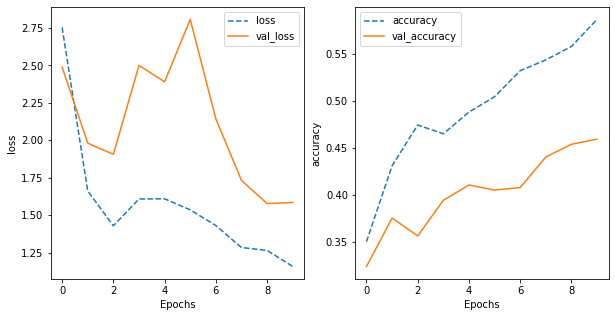

In [8]:
model = train_and_evaluate(batch_size=32, lrate=0.0001, l1=0, l2=0, num_hidden=256)

### Regularisation

Epoch 1/10
104/104 [==============================] - 105s 1s/step - loss: 2.3646 - accuracy: 0.3670 - val_loss: 2.0068 - val_accuracy: 0.4162
Epoch 2/10
104/104 [==============================] - 114s 1s/step - loss: 1.7655 - accuracy: 0.4233 - val_loss: 2.4270 - val_accuracy: 0.4162
Epoch 3/10
104/104 [==============================] - 108s 1s/step - loss: 1.7390 - accuracy: 0.4479 - val_loss: 2.1758 - val_accuracy: 0.4270
Epoch 4/10
104/104 [==============================] - 107s 1s/step - loss: 1.5963 - accuracy: 0.4903 - val_loss: 1.9705 - val_accuracy: 0.4324
Epoch 5/10
104/104 [==============================] - 106s 1s/step - loss: 1.4946 - accuracy: 0.5279 - val_loss: 1.8710 - val_accuracy: 0.4486
Epoch 6/10
104/104 [==============================] - 104s 997ms/step - loss: 1.3877 - accuracy: 0.5548 - val_loss: 1.8922 - val_accuracy: 0.4459
Epoch 7/10
104/104 [==============================] - 103s 992ms/step - loss: 1.3949 - accuracy: 0.5558 - val_loss: 1.9203 - val_accuracy: 

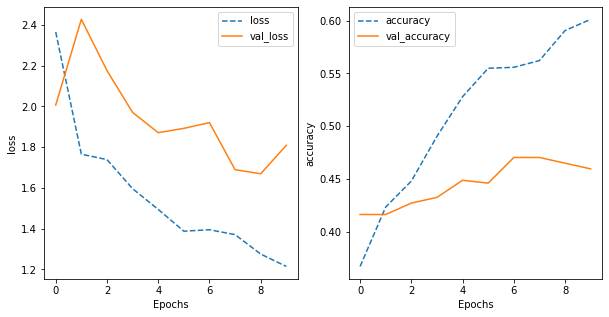

In [9]:
model = train_and_evaluate(batch_size=32, lrate=0.0001, l1=0, l2=0.001, num_hidden=128)

### Early stopping

In [16]:
regularizer = tf.keras.regularizers.l1_l2(0, 0.001)
model = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
  tf.keras.layers.Dense(units=128, kernel_regularizer=regularizer, activation='relu'),
  tf.keras.layers.Dense(len(CLASS_NAMES), kernel_regularizer=regularizer, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])

history = model.fit(train_dataset, validation_data=eval_dataset, epochs=10, callbacks=[tf.keras.callbacks.EarlyStopping(patience=1)])

Epoch 1/10
104/104 [==============================] - 124s 1s/step - loss: 2.4038 - accuracy: 0.3442 - val_loss: 1.8382 - val_accuracy: 0.3946
Epoch 2/10
104/104 [==============================] - 107s 1s/step - loss: 1.6346 - accuracy: 0.4439 - val_loss: 1.9642 - val_accuracy: 0.3568


## Hyperparameter tuning

In [17]:
!pip install -q keras-tuner

In [19]:
import kerastuner as kt

def build_model(hp):
  lrate = hp.Float('lrate', 1e-4, 1e-1, sampling='log')
  l1 = 0
  l2 = hp.Choice('l2', values=[0.0, 1e-1, 1e-2, 1e-3, 1e-4])
  num_hidden = hp.Int('num_hidden', 32, 256, 32)
  
  regularizer = tf.keras.regularizers.l1_l2(l1, l2)

  # Neural network with one hidden layer
  model = tf.keras.Sequential([
        tf.keras.layers.Flatten(
            input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
        tf.keras.layers.Dense(
            units=num_hidden,
            kernel_regularizer=regularizer,
            activation='relu'),
        tf.keras.layers.Dense(
            units=len(CLASS_NAMES), 
            kernel_regularizer=regularizer,
            activation='softmax')
                              
  ])
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])
  return model

batch_size = 32

train_dataset = tf.data.TextLineDataset(
    'gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv'
).map(decode_csv).batch(batch_size)

eval_dataset = tf.data.TextLineDataset(
    'gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/eval_set.csv'
).map(decode_csv).batch(batch_size)

tuner = kt.BayesianOptimization(
    build_model,
    objective=kt.Objective('val_accuracy', 'max'),
    max_trials=10,
    num_initial_points=2,
    overwrite=False) # True to start afresh

tuner.search(
    train_dataset, validation_data=eval_dataset,
    epochs=5,
    callbacks=[tf.keras.callbacks.EarlyStopping(
        patience=1
    )]
)

Trial 10 Complete [00h 11m 50s]
val_accuracy: 0.4513513445854187

Best val_accuracy So Far: 0.49459460377693176
Total elapsed time: 01h 22m 00s
INFO:tensorflow:Oracle triggered exit


In [21]:
# Get topN trials
topN = 2
for x in range(topN):
  print(tuner.get_best_hyperparameters(topN)[x].values)
  print(tuner.get_best_models(topN)[x].summary())

{'lrate': 0.0001, 'l2': 0.01, 'num_hidden': 256}
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 150528)            0         
                                                                 
 dense (Dense)               (None, 256)               38535424  
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 38,536,709
Trainable params: 38,536,709
Non-trainable params: 0
_________________________________________________________________
None
{'lrate': 0.0001, 'l2': 0.0, 'num_hidden': 256}
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 150528)           